In [1]:
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools, places
%matplotlib inline

In [2]:
jS3,iS3=places.PLACES['S3']['NEMO grid ji']

In [3]:
places.PLACES['Juan de Fuca Strait']

{'lon lat': (-124.7, 48.47)}

In [4]:
jJF,iJF=[290,130]

In [5]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    dept=np.copy(fm.variables['gdept_1d'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]

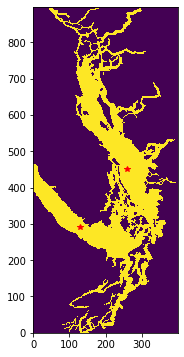

In [6]:
fig,ax=plt.subplots(1,1,figsize=(4,6))
ax.pcolormesh(tmask[0,0,:,:])
ax.plot(130,290,'r*')
ax.plot(iS3,jS3,'r*')
ax.set_aspect(1)

In [7]:
jpk40=0
for i in range(0,40):
    if dept[0][i]<=40:
        jpk40=i
print(jpk40)
jpk40=jpk40+1
print(jpk40)

22
23


In [8]:
koff=jpk40 # first index of depth > 40

In [9]:
t0=dt.datetime(2015,1,1) # 1st start date of run
#te=dt.datetime(2016,12,1)# last start date of runfnum=18
stm=np.shape(tmask)
#nlen=36*2
nlen=365
dlist=[t0+dt.timedelta(days=ii) for ii in range(0,nlen)]

In [10]:
#sdir0='/results/SalishSea/nowcast-green/'
#sdir1='/results/SalishSea/hindcast/'
#sdir3='/data/eolson/MEOPAR/SS36runs/CedarRuns/spring2015_HCMZ/'
#sdir1='/results2/SalishSea/nowcast-green.201905/'
sdir1='/results/SalishSea/nowcast-green.201812/'

In [11]:
tmaskC=np.copy(tmask)
tmaskC[:,koff:,:,:]=0
#tmaskC[:,:,370:490,:12]=0
#tmaskC[:,:,887:,30:70]=0

In [12]:
tlist=dlist
idir=sdir1
fformat1='%d%b%y/'
fformatT='SalishSea_1h_%Y%m%d_%Y%m%d_ptrc_T.nc'
fformatP='SalishSea_1h_%Y%m%d_%Y%m%d_carp_T.nc'
meanMESZ40=np.zeros((len(tlist),))
meanMESZAll=np.zeros((len(tlist),))
meanMESZ40S3=np.zeros((len(tlist),))
meanMESZAllS3=np.zeros((len(tlist),))
meanMESZ40JF=np.zeros((len(tlist),))
meanMESZAllJF=np.zeros((len(tlist),))
#meanprey=np.zeros((len(tlist),)
ind=-1
for idt0 in tlist:
    ind=ind+1
    cdir=idt0.strftime(fformat1).lower()
    iffT=idt0.strftime(fformatT)
    iffP=idt0.strftime(fformatP)
    sffT=idir+cdir+iffT
    sffP=idir+cdir+iffP
    f=nc.Dataset(glob.glob(sffT)[0])
    if ind%15==0: print(sffT) 
    fP=nc.Dataset(glob.glob(sffP)[0])
    #e3t=fP.variables['e3t'][:2,:,:,:]
    Vol=A*e3t_0
    meanMESZ40[ind]=np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*f.variables['mesozooplankton'][0,:,:,:])/\
            np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:])#mmol/m3
    meanMESZAll[ind]=np.sum(tmask[0,:,:,:]*Vol[0,:,:,:]*f.variables['mesozooplankton'][0,:,:,:])/\
            np.sum(tmask[0,:,:,:]*Vol[0,:,:,:])#mmol/m3
    meanMESZ40S3[ind]=np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['mesozooplankton'][0,:,jS3,iS3])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3
    meanMESZAllS3[ind]=np.sum(tmask[0,:,jS3,iS3]*Vol[0,:,jS3,iS3]*f.variables['mesozooplankton'][0,:,jS3,iS3])/\
            np.sum(tmask[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3
    meanMESZ40JF[ind]=np.sum(tmaskC[0,:,jJF,iJF]*Vol[0,:,jJF,iJF]*f.variables['mesozooplankton'][0,:,jJF,iJF])/\
            np.sum(tmaskC[0,:,jS3,iS3]*Vol[0,:,jS3,iS3])#mmol/m3
    meanMESZAllJF[ind]=np.sum(tmask[0,:,jJF,iJF]*Vol[0,:,jJF,iJF]*f.variables['mesozooplankton'][0,:,jJF,iJF])/\
            np.sum(tmask[0,:,jJF,iJF]*Vol[0,:,jJF,iJF])#mmol/m3
    #sumprey=f.variables['diatoms'][0,:,:,:]+f.variables['particulate_organic_nitrogen'][0,:,:,:]+f.variables['ciliates'][0,:,:,:]+\
    #        f.variables['flagellates'][0,:,:,:]+f.variables['microzooplankton'][0,:,:,:]
    #meanprey[ind,:]=np.sum(np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:]*sumprey,2),1)/\
    #        np.sum(np.sum(tmaskC[0,:,:,:]*Vol[0,:,:,:],2),1)#mmol/m3)
    f.close()
    fP.close()

/results/SalishSea/nowcast-green.201812/01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/16jan15/SalishSea_1h_20150116_20150116_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/31jan15/SalishSea_1h_20150131_20150131_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/15feb15/SalishSea_1h_20150215_20150215_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/02mar15/SalishSea_1h_20150302_20150302_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/17mar15/SalishSea_1h_20150317_20150317_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/01apr15/SalishSea_1h_20150401_20150401_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/16apr15/SalishSea_1h_20150416_20150416_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/01may15/SalishSea_1h_20150501_20150501_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/16may15/SalishSea_1h_20150516_20150516_ptrc_T.nc
/results/SalishSea/nowcast-green.201812/31may15/SalishSea_1h_20150531_20150531_ptrc_T.nc
/results/SalishSea/no

Text(0.5, 1.0, 'Seasonality of Model Mean Mesozooplankton Conentration')

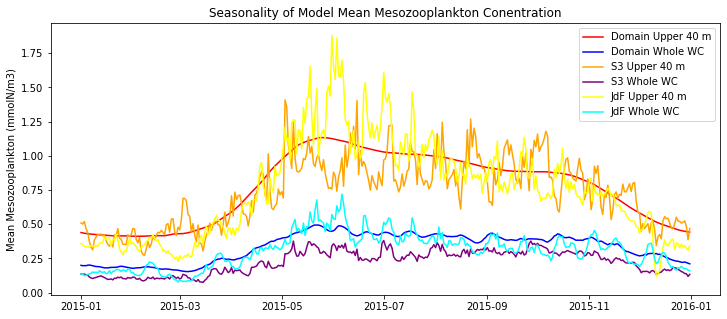

In [13]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
ax.plot(tlist,meanMESZ40,'r-',label='Domain Upper 40 m')
ax.plot(tlist,meanMESZAll,'b-',label='Domain Whole WC ')
ax.plot(tlist,meanMESZ40S3,'-',color='orange',label='S3 Upper 40 m')
ax.plot(tlist,meanMESZAllS3,'-',color='purple',label='S3 Whole WC')
ax.plot(tlist,meanMESZ40JF,'-',color='yellow',label='JdF Upper 40 m')
ax.plot(tlist,meanMESZAllJF,'-',color='cyan',label='JdF Whole WC')
ax.legend()
ax.set_ylabel('Mean Mesozooplankton (mmolN/m3)')
ax.set_title('Seasonality of Model Mean Mesozooplankton Conentration')